In [1]:
import torch

## Render our simple world with no pendulum (it's empty)


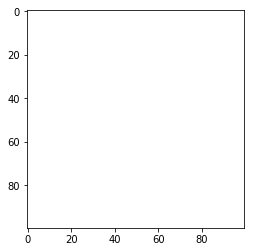

In [2]:
img = torch.zeros((100,100))

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Get a state of the pendulum

<p align="center">
  <img src="simple_pend.svg" width="250"/>
</p>

In [3]:
## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2

## state

theta    = 1.0 # angle from down
thetadot = 0 # 

state = torch.FloatTensor([theta, thetadot])
print state


 1
 0
[torch.FloatTensor of size 2]



## Convert state of pendulum to line segment

In [4]:
base = torch.FloatTensor([0,0])  # in world coordinates

def convert_world_to_img_coordinates(world_coordinates):
    return world_coordinates + 50


base_in_img = convert_world_to_img_coordinates(base)


length_x = l * torch.cos(state[0:1])
length_y = l * torch.sin(state[0:1])

length = torch.cat((length_x, length_y))

end = base + length
end_in_img = convert_world_to_img_coordinates(end)

## Find all pixels close enough to line segment


In [5]:
import numpy as np
pi = np.pi

In [6]:
def torch_flip(two_element_tensor):
    return torch.FloatTensor([two_element_tensor[1],two_element_tensor[0]])
    
def torch_det(A,B):
    return A[0]*B[1] - A[1]*B[0]


def distance_pytorch(A, B, P):
    if (A == B).all() or (B == P).all():
        return 0
    if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), 
                                                (B - A) / (B - A).norm())])) > pi/2).all():
        return (P - A).norm()
    
    if (torch.acos(torch.FloatTensor([torch.dot((P - B) / (P - B).norm(), 
                                                (A - B) / (A - B).norm())])) > pi/2).all():
        return (P - B).norm()
    
    return abs(torch_det(A-B, A-P))/(B-A).norm()


 50
 50
[torch.FloatTensor of size 2]


 66.2091
 75.2441
[torch.FloatTensor of size 2]



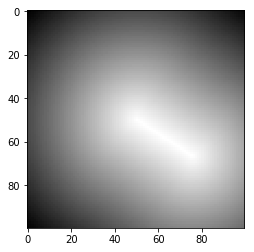

In [7]:
print base_in_img
print end_in_img

img = torch.zeros((100,100))

for i, row in enumerate(img):
    for j, val in enumerate(row):
        this_img_coord = torch.FloatTensor([i,j])
        img[i,j] = distance_pytorch(base_in_img, end_in_img, this_img_coord)

plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()

## Render pendulum

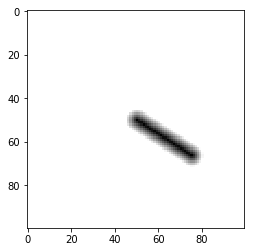

In [8]:
img = torch.zeros((100,100))

for i, row in enumerate(img):
    for j, val in enumerate(row):
        this_img_coord = torch.FloatTensor([i,j])
        dist = distance_pytorch(base_in_img, end_in_img, this_img_coord)
        if dist < 5.0:
            img[i,j] = 5 - dist

plt.imshow(img, cmap=plt.get_cmap('gray_r'))
plt.show()


## Get states of pendulum over time

In [50]:
## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2
m = 1.0    # mass in kg
b = 10.0    # damping

## initial state

theta    = 1.0 # angle from down
thetadot = 0 # 

state = torch.FloatTensor([theta, thetadot])

def stabilize_upright_controller(state):
    theta_desired = np.pi
    diff_pos = (np.pi - state[0])
    diff_vel = (0     - state[1])
    u = 1000*diff_pos + 100*diff_vel
    if u > 500:
        u = 500
    if u < -500:
        u = -500
    return u
    
def pendulum_next_state(state, u):
    deriv = torch.zeros(2)
    deriv[0] = state[1]
    deriv[1] = float(-(m * g * l * torch.sin(state[0:1])) - b*state[1] + u)
    dt = .01
    next_state = state + deriv*dt
    return next_state

print state
print pendulum_next_state(state,0)
print pendulum_next_state(state,0)
print pendulum_next_state(pendulum_next_state(state,0),0)

state_tape = []
state_tape.append(state)

for i in range(100):
    u = stabilize_upright_controller(state_tape[-1])
    next_state = pendulum_next_state(state_tape[-1],u)
    state_tape.append(next_state)
    
print len(state_tape)

print state_tape[1]
print state_tape[6]


 1
 0
[torch.FloatTensor of size 2]


 1.0000
-2.4739
[torch.FloatTensor of size 2]


 1.0000
-2.4739
[torch.FloatTensor of size 2]


 0.9753
-4.7005
[torch.FloatTensor of size 2]

101

 1.0000
 2.5261
[torch.FloatTensor of size 2]


  1.3269
 11.2457
[torch.FloatTensor of size 2]



In [51]:
base = torch.FloatTensor([0,0])  # in world coordinates
base_in_img = convert_world_to_img_coordinates(base)

def pendulum_state_to_img(state):
    length_x = l * torch.cos(state[0:1])
    length_y = l * torch.sin(state[0:1])

    length = torch.cat((length_x, length_y))

    end = base + length
    end_in_img = convert_world_to_img_coordinates(end)
    
    img = torch.zeros((100,100))

    for i, row in enumerate(img):
        for j, val in enumerate(row):
            this_img_coord = torch.FloatTensor([i,j])
            dist = distance_pytorch(base_in_img, end_in_img, this_img_coord)
            if dist < 5.0:
                img[i,j] = 5 - dist

    return img


img_tape = []

for i in state_tape:
    img_tape.append(pendulum_state_to_img(i))
    
print len(img_tape)

101


In [52]:
# %matplotlib inline
# for i in img_tape:
#     plt.imshow(i, cmap=plt.get_cmap('gray_r'))
#     plt.show()

<IPython.core.display.Javascript object>


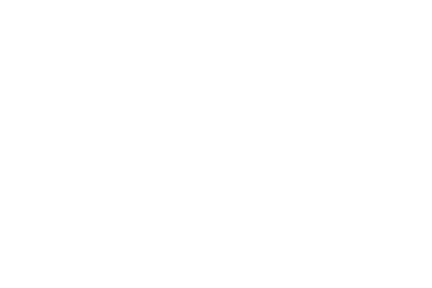

In [53]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
first_img = img_tape[0]
im = plt.imshow(first_img, cmap='gist_gray_r')

def init():
    im.set_data(first_img)

def animate(i):
    im.set_data(img_tape[i])
    return im
    
animate = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_tape), interval=20, blit=True)
plt.close(fig)
HTML(animate.to_html5_video())

In [54]:
# plotting etc examples for reference
# https://gist.github.com/AndrewWalker/2687988
# https://matplotlib.org/examples/animation/double_pendulum_animated.html